# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFlite_Version  = "1106"   
TFlite_MainType = "ana-cont"
TFlite_Size     = "s2"
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(6633, 32, 32, 3)
(6633, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(inputs3)
inputs5 = tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(128,activation="relu")(inputs9)
inputs11 = tf.keras.layers.Dense(64,activation="relu")(inputs10)
output = tf.keras.layers.Dense(2)(inputs11)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          12816     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0     

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/30


C:\Users\Muell\AppData\Local\Temp\ipykernel_17512\3831122756.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


830/830 [==============================] - 14s 16ms/step - loss: 0.1793 - accuracy: 0.8265 - val_loss: 0.0757 - val_accuracy: 0.9322
Epoch 2/30
830/830 [==============================] - 12s 14ms/step - loss: 0.0507 - accuracy: 0.9386 - val_loss: 0.0611 - val_accuracy: 0.9013
Epoch 3/30
830/830 [==============================] - 12s 14ms/step - loss: 0.0337 - accuracy: 0.9522 - val_loss: 0.0185 - val_accuracy: 0.9676
Epoch 4/30
830/830 [==============================] - 13s 15ms/step - loss: 0.0246 - accuracy: 0.9573 - val_loss: 0.0179 - val_accuracy: 0.9623
Epoch 5/30
830/830 [==============================] - 12s 15ms/step - loss: 0.0170 - accuracy: 0.9683 - val_loss: 0.0117 - val_accuracy: 0.9744
Epoch 6/30
830/830 [==============================] - 12s 15ms/step - loss: 0.0141 - accuracy: 0.9656 - val_loss: 0.0098 - val_accuracy: 0.9774
Epoch 7/30
830/830 [==============================] - 13s 15ms/step - loss: 0.0117 - accuracy: 0.9700 - val_loss: 0.0104 - val_accuracy: 0.9736
Epo

### Step 1: Learing result
 
* Visualization of the training and validation results

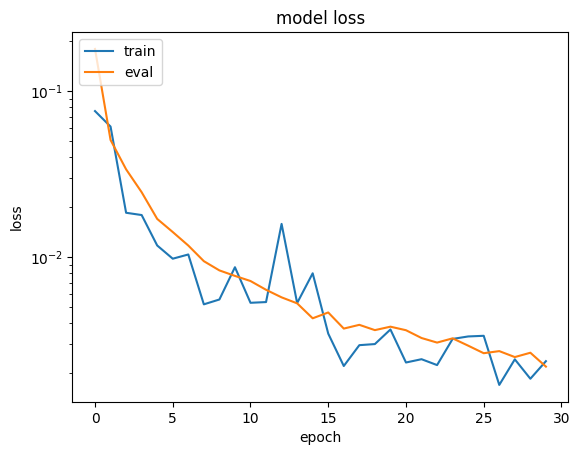

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/160
  5/830 [..............................] - ETA: 12s - loss: 0.4449 - accuracy: 0.7750

C:\Users\Muell\AppData\Local\Temp\ipykernel_17512\1492021130.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


830/830 [==============================] - 13s 16ms/step - loss: 0.1194 - accuracy: 0.8922 - val_loss: 0.0538 - val_accuracy: 0.9540
Epoch 2/160
830/830 [==============================] - 13s 16ms/step - loss: 0.0463 - accuracy: 0.9462 - val_loss: 0.0405 - val_accuracy: 0.9548
Epoch 3/160
830/830 [==============================] - 13s 15ms/step - loss: 0.0350 - accuracy: 0.9561 - val_loss: 0.0276 - val_accuracy: 0.9653
Epoch 4/160
830/830 [==============================] - 13s 16ms/step - loss: 0.0301 - accuracy: 0.9593 - val_loss: 0.0243 - val_accuracy: 0.9616
Epoch 5/160
830/830 [==============================] - 13s 16ms/step - loss: 0.0215 - accuracy: 0.9640 - val_loss: 0.0204 - val_accuracy: 0.9638
Epoch 6/160
830/830 [==============================] - 14s 17ms/step - loss: 0.0189 - accuracy: 0.9673 - val_loss: 0.0215 - val_accuracy: 0.9661
Epoch 7/160
830/830 [==============================] - 14s 17ms/step - loss: 0.0153 - accuracy: 0.9689 - val_loss: 0.0163 - val_accuracy: 0.96

830/830 [==============================] - 7s 8ms/step - loss: 0.0035 - accuracy: 0.9825 - val_loss: 0.0052 - val_accuracy: 0.9797
Epoch 58/160
830/830 [==============================] - 6s 7ms/step - loss: 0.0036 - accuracy: 0.9824 - val_loss: 0.0024 - val_accuracy: 0.9812
Epoch 59/160
830/830 [==============================] - 6s 7ms/step - loss: 0.0033 - accuracy: 0.9842 - val_loss: 0.0027 - val_accuracy: 0.9819
Epoch 60/160
830/830 [==============================] - 6s 7ms/step - loss: 0.0035 - accuracy: 0.9822 - val_loss: 0.0044 - val_accuracy: 0.9842
Epoch 61/160
830/830 [==============================] - 7s 8ms/step - loss: 0.0034 - accuracy: 0.9839 - val_loss: 0.0039 - val_accuracy: 0.9857
Epoch 62/160
830/830 [==============================] - 9s 11ms/step - loss: 0.0031 - accuracy: 0.9842 - val_loss: 0.0032 - val_accuracy: 0.9804
Epoch 63/160
830/830 [==============================] - 8s 9ms/step - loss: 0.0030 - accuracy: 0.9828 - val_loss: 0.0023 - val_accuracy: 0.9797
Epoc

Epoch 114/160
830/830 [==============================] - 6s 7ms/step - loss: 0.0022 - accuracy: 0.9861 - val_loss: 0.0026 - val_accuracy: 0.9879
Epoch 115/160
830/830 [==============================] - 6s 8ms/step - loss: 0.0021 - accuracy: 0.9881 - val_loss: 0.0018 - val_accuracy: 0.9910
Epoch 116/160
830/830 [==============================] - 7s 8ms/step - loss: 0.0022 - accuracy: 0.9888 - val_loss: 0.0019 - val_accuracy: 0.9887
Epoch 117/160
830/830 [==============================] - 8s 9ms/step - loss: 0.0019 - accuracy: 0.9881 - val_loss: 0.0016 - val_accuracy: 0.9887
Epoch 118/160
830/830 [==============================] - 6s 8ms/step - loss: 0.0023 - accuracy: 0.9854 - val_loss: 0.0015 - val_accuracy: 0.9857
Epoch 119/160
830/830 [==============================] - 6s 7ms/step - loss: 0.0020 - accuracy: 0.9890 - val_loss: 0.0028 - val_accuracy: 0.9857
Epoch 120/160
830/830 [==============================] - 6s 7ms/step - loss: 0.0019 - accuracy: 0.9867 - val_loss: 0.0014 - val_ac

### Overall Learing results (Step 1 & Step 2)

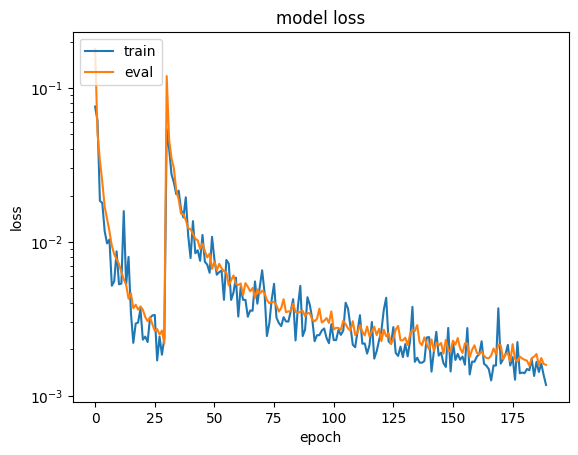

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img, verbose=0)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\0.0_0042_zeiger4_2019-06-05T015009.jpg 0.0 0.06950852525118796 -0.06950852525118796
data_resize_all\0.0_557d5cc3b6660acee736809eec9df6e7.jpg 0.0 0.0724485280043638 -0.0724485280043638
data_resize_all\0.0_name_20230216-061847.jpg 0.0 -0.06351547537088564 0.06351547537088564
data_resize_all\0.0_name_20230216-062347.jpg 0.0 -0.07566566568311295 0.07566566568311295
data_resize_all\0.0_name_20230216-191846.jpg 0.0 -0.07057198096177197 0.07057198096177197
data_resize_all\0.1_PRODUCED_ANALOG.jpg 0.01 0.09138113885109599 -0.08138113885109599
data_resize_all\0.1_PRODUCED_ANALOG_2.jpg 0.01 0.17483633646183222 -0.1648363364618322
data_resize_all\0.1_analog3_20201006-025717.jpg 0.01 0.0661531141872415 -0.0561531141872415
data_resize_all\0.5_4e2893dbd109753be2b792ef22e31ad1.jpg 0.05 0.115413149959412 -0.065413149959412
data_resize_all\0.5_f38f2eb5263c3f8159ae2d2a7168d5d5.jpg 0.05 0.11513415570456467 -0.06513415570456467
data_resize_all\0.5_name_20230216-063347.jpg 0.05 -0.0116087021

data_resize_all\2.9_name_20230216-181846.jpg 0.29 -0.04403750712123644 0.3340375071212364
data_resize_all\3.0_name_20230216-065347.jpg 0.3 0.031323219074556936 0.26867678092544306
data_resize_all\3.0_name_20230216-100847.jpg 0.3 -0.04224118634227081 0.3422411863422708
data_resize_all\3.0_name_20230216-122847.jpg 0.3 -0.0554427324952399 0.3554427324952399
data_resize_all\3.1_name_20230216-102347.jpg 0.31 -0.007353001019685057 0.31735300101968505
data_resize_all\3.2_name_20230216-080347.jpg 0.32 -0.13950603512870574 0.45950603512870575
data_resize_all\3.2_name_20230216-123347.jpg 0.32 -0.06261977195222923 0.38261977195222924
data_resize_all\3.3_deb59dd19c8a3f5b349510e3acc49663.jpg 0.32999999999999996 0.2252297567494017 0.10477024325059825
data_resize_all\3.3_name_20230216-133847.jpg 0.32999999999999996 -0.08219126161845158 0.41219126161845154
data_resize_all\3.3_name_20230216-233346.jpg 0.32999999999999996 -0.12794593995845915 0.4579459399584591
data_resize_all\3.4_0519261f9349ecd8167b3b

data_resize_all\6.2_name_20230216-151847.jpg 0.62 0.7678980863626853 -0.1478980863626853
data_resize_all\6.2_name_20230216-221846.jpg 0.62 0.8457273709905683 -0.22572737099056828
data_resize_all\6.3_name_20230216-010348.jpg 0.63 0.89044907808235 -0.26044907808234996
data_resize_all\6.3_name_20230216-183346.jpg 0.63 0.8935064415095769 -0.2635064415095769
data_resize_all\6.4_PRODUCED_ANALOG_2.jpg 0.64 0.7153626238876614 -0.07536262388766135
data_resize_all\6.4_name_20230216-072347.jpg 0.64 0.8048181806297492 -0.16481818062974918
data_resize_all\6.4_name_20230216-124347.jpg 0.64 0.8292484202257985 -0.18924842022579846
data_resize_all\6.4_name_20230216-152847.jpg 0.64 0.7098311951883265 -0.06983119518832648
data_resize_all\6.5_name_20230216-010848.jpg 0.65 0.8252278673163659 -0.17522786731636586
data_resize_all\6.5_name_20230216-011348.jpg 0.65 0.7648456748226067 -0.11484567482260666
data_resize_all\6.5_name_20230216-012348.jpg 0.65 0.8000622250469309 -0.1500622250469309
data_resize_all\6.

data_resize_all\8.3_4149_zeiger3_2019-06-01T191021.jpg 0.8300000000000001 0.9630993195970146 -0.1330993195970145
data_resize_all\8.3_4150_zeiger3_2019-06-01T192013.jpg 0.8300000000000001 0.8994771082907866 -0.06947710829078657
data_resize_all\8.3_4151_zeiger3_2019-06-01T193014.jpg 0.8300000000000001 0.9595139967765063 -0.1295139967765062
data_resize_all\8.3_4152_zeiger3_2019-06-01T194012.jpg 0.8300000000000001 0.9636462635959575 -0.13364626359595744
data_resize_all\8.3_4153_zeiger3_2019-06-01T195015.jpg 0.8300000000000001 0.963907489872589 -0.13390748987258894
data_resize_all\8.3_4154_zeiger3_2019-06-01T200012.jpg 0.8300000000000001 0.9324056257773343 -0.10240562577733425
data_resize_all\8.3_4155_zeiger3_2019-06-01T204131.jpg 0.8300000000000001 0.9487901539200155 -0.11879015392001546
data_resize_all\8.3_PRODUCED_ANALOG_2.jpg 0.8300000000000001 0.9767361693583054 -0.14673616935830536
data_resize_all\8.3_name_20230216-202346.jpg 0.8300000000000001 0.8997911452106256 -0.06979114521062557


## Results

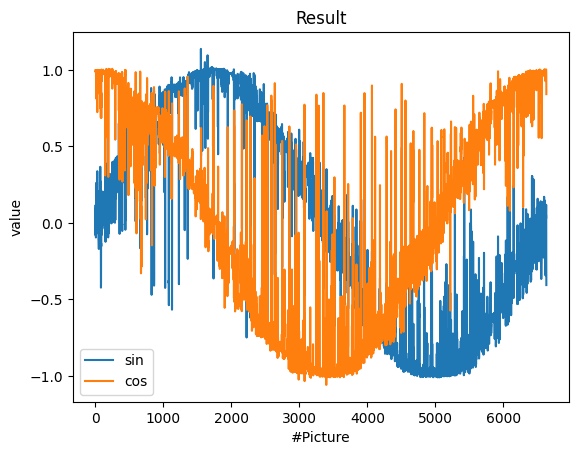

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

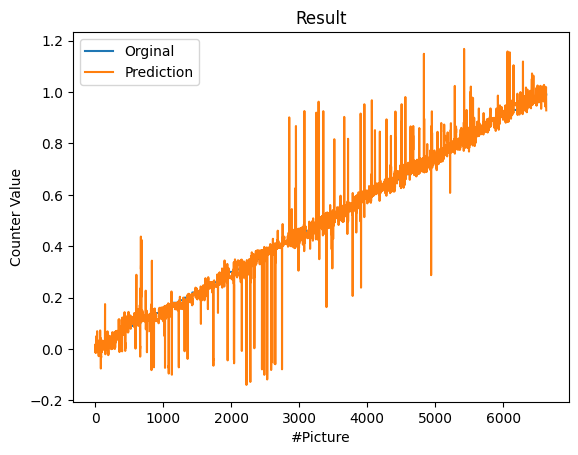

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

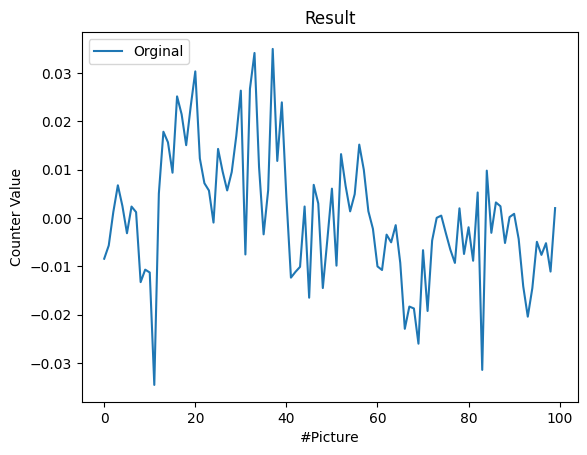

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

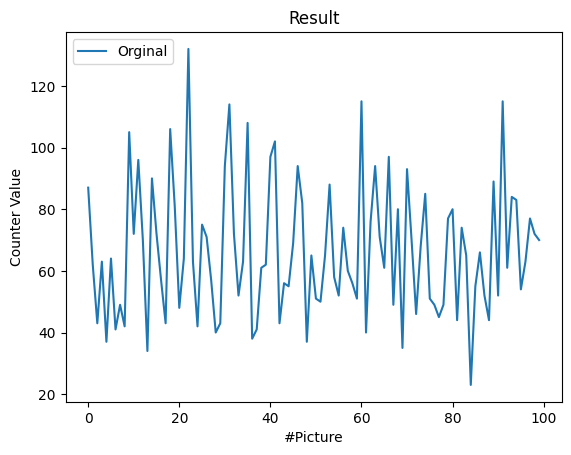

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

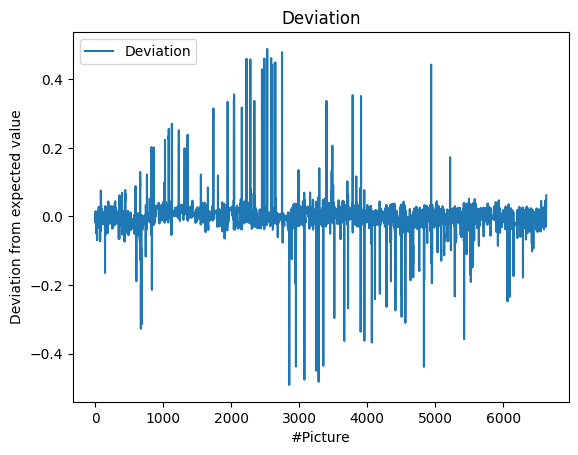

[-0.0001  0.0451 -0.4912  0.4883]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp46z2y9hz\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp46z2y9hz\assets


183756

In [15]:
from pathlib import Path
import tensorflow as tf

FileName = FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + "_q.tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpafex0x8h\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpafex0x8h\assets
C:\Users\Muell\anaconda3\envs\py39-td-opencv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


ana-cont_1106_s2_q.tflite


53328